# 1. Importation des packages

In [1]:
import pandas as pd
import nltk
import re
from bs4 import BeautifulSoup 
import string 
from collections import defaultdict
from nltk.corpus import wordnet as wn
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
import time
import matplotlib.pyplot as plt
from wordcloud import WordCloud
tqdm.pandas()

In [2]:
stopwords_list = nltk.corpus.stopwords.words('english')

# 2. Importation des données et Explanatory Data Analysis (EDA à compléter)

In [3]:
amazon = pd.read_csv(r'C:\Users\Bastien\Desktop\Data - Rapport\0. Base de données\1. Saved versions\amazon_reviews_balanced.csv',sep=',',encoding='utf-8')
amazon = amazon.loc[:, ~amazon.columns.str.contains('^Unnamed')]
amazon.head()

,reviewText,Category,Positivité
0,"Well, I've already had to use them and they pe...",Sports and Outdoor,5
1,The size of this hipster was good. The new col...,Clothing SHoes and Jewelry,5
2,These are beyond amazing. they look amazing an...,Clothing SHoes and Jewelry,5
3,Great Classic Pistol just like the ones of my ...,Sports and Outdoor,5
4,"I always use Formbys tung oil, and this high g...",Tools and Home Improvements,5


In [4]:
amazon = amazon.drop_duplicates(subset="reviewText")
amazon = amazon.dropna(subset=['reviewText'],axis=0)
amazon.reset_index(drop = True, inplace = True)
amazon.shape

(195367, 3)

In [5]:
amazon['Positivité'].value_counts()

5    39167
4    39143
3    39081
1    39019
2    38957
Name: Positivité, dtype: int64

# 3. Data pre-processing

## 3.1. Pre-processing functions

In [6]:
# Create a contraction dictionnary and functions to replace them according to the dictionnary
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "i'd": "i would", "i'i've": "i would have", "i'll": "i will", "i'll've": "i will have","i'm": "i am", "i've": "i have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re

contractions, contractions_re = _get_contractions(contraction_dict)

def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)

In [7]:
# Part-Of-Speech (POS) Tagging preparation for lemmatization to go from pos_tag to lemmatizer
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

In [8]:
# Lemmatization and stopwords removal functions
def lemmatization(text):
    lemmatizer = WordNetLemmatizer()
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    tokens = [lemmatizer.lemmatize(token,tag_map[tag[0]]) for token, tag in pos_tag(tokens)]
    return tokens


def stopwords_removal(text):
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    filtered_tokens = [token for token in tokens if token.lower() not in stopwords_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

In [9]:
# General cleaning function
def cleaning(text,stopwords):
    # remove first special caracters and numbers
    text = re.sub('<.*?!>\/',' ',str(text))
    text = re.sub('[0-9]+', '', str(text))
    # lowerisation of whole text
    text = text.lower()
    # remove html and links 
    soup = BeautifulSoup(text,'lxml')
    html_free = soup.get_text()
    # replace contractions
    text = replace_contractions(text)
    # remove punctuation
    translator = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    text = text.translate(translator)
    # tokenization & stop words removal if needed
    if stopwords == False:
        text = stopwords_removal(text)
    elif stopwords == True:
        pass
    # tokenization & lemmatization 
    text = lemmatization(text)
    return text

def preprocessing(vecteur,stopwords):
    vecteur = vecteur.progress_apply(lambda x : cleaning(x,stopwords))
    return vecteur

## 3.2. Pre-processing (two made : one with, the other without stopwords)

In [10]:
start = time.time()
final_string_w_stop = preprocessing(amazon['reviewText'],stopwords = True)
end = time.time()
print("Temps en minutes =", (end - start)/60)


Temps en minutes = 22.91622523466746


In [11]:
amazon['CleanedText_With_Stop']=final_string_w_stop
amazon.head()

,reviewText,Category,Positivité,CleanedText_With_Stop
0,"Well, I've already had to use them and they pe...",Sports and Outdoor,5,"[well, i, have, already, have, to, use, them, ..."
1,The size of this hipster was good. The new col...,Clothing SHoes and Jewelry,5,"[the, size, of, this, hipster, be, good, the, ..."
2,These are beyond amazing. they look amazing an...,Clothing SHoes and Jewelry,5,"[these, be, beyond, amaze, they, look, amaze, ..."
3,Great Classic Pistol just like the ones of my ...,Sports and Outdoor,5,"[great, classic, pistol, just, like, the, one,..."
4,"I always use Formbys tung oil, and this high g...",Tools and Home Improvements,5,"[i, always, use, formbys, tung, oil, and, this..."


In [12]:
start = time.time()
final_string = preprocessing(amazon['reviewText'],stopwords = False)
end = time.time()
print("Temps en minutes =", (end - start)/60)


Temps en minutes = 17.294468382994335


In [13]:
amazon['CleanedText']=final_string
amazon.head()

,reviewText,Category,Positivité,CleanedText_With_Stop,CleanedText
0,"Well, I've already had to use them and they pe...",Sports and Outdoor,5,"[well, i, have, already, have, to, use, them, ...","[well, already, use, perform, well, easy, hand..."
1,The size of this hipster was good. The new col...,Clothing SHoes and Jewelry,5,"[the, size, of, this, hipster, be, good, the, ...","[size, hipster, good, new, color, outstanding,..."
2,These are beyond amazing. they look amazing an...,Clothing SHoes and Jewelry,5,"[these, be, beyond, amaze, they, look, amaze, ...","[beyond, amazing, look, amaze, get, comment, e..."
3,Great Classic Pistol just like the ones of my ...,Sports and Outdoor,5,"[great, classic, pistol, just, like, the, one,...","[great, classic, pistol, like, one, childhood,..."
4,"I always use Formbys tung oil, and this high g...",Tools and Home Improvements,5,"[i, always, use, formbys, tung, oil, and, this...","[always, use, formbys, tung, oil, high, gloss,..."


## 3.3. Saving pre-processed file

In [14]:
amazon.to_csv(r'C:\Users\Bastien\Desktop\Data - Rapport\0. Base de données\1. Saved versions\amazon_reviews_balanced_prepro.csv',sep=',')

In [15]:
pd.isnull(amazon['CleanedText']).sum()

0

# 4. Explanatory Data Analysis

## 4.1. Wordclouds

### 4.1.1. WordCloud Automotive

In [27]:
stop_words = stopwords.words("english")
automotive_words = ''

for text in tqdm(amazon[amazon['Category']=='Automotive']['CleanedText']):
    for tokens in text:
        automotive_words = automotive_words + tokens + ' '

NameError: name 'WordCloud' is not defined

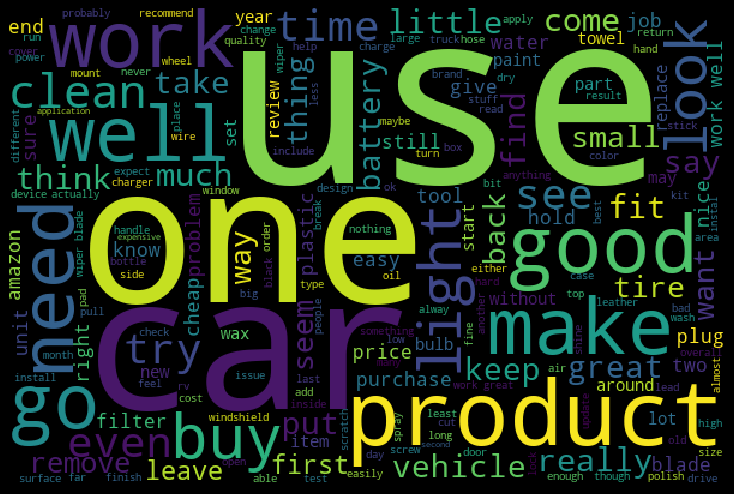

In [36]:
# Generate a word cloud image
auto_wordcloud = WordCloud(width=600, height=400).generate(automotive_words)
#Insincere Word cloud
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(auto_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

### 4.1.2. WordCloud Negative reviews for Cellphones and Accessories

In [57]:
stop_words = stopwords.words("english")
cell_neg_words = ''
cell_neg_word =''
cell = amazon[amazon['Category']=='Cell Phones and Accessories']
cell_neg = cell[cell['Positivité'] > 3]
no = ['phone','use','need','well','go','one','think','really','work','product','make','even','look','buy','good','great']
for text in tqdm(cell_neg['CleanedText']):
    cell_neg_word = cell_neg_word + ' '.join(token for token in text if token not in no)

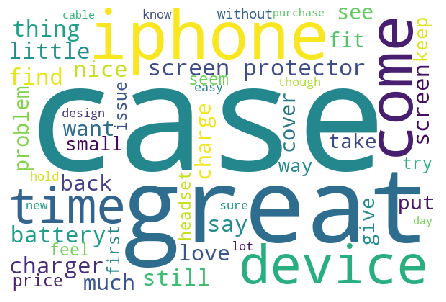

In [59]:
# Generate a word cloud image
neg_cell_wordcloud = WordCloud(width=600, height=400,max_words=50,background_color="white",contour_color='steelblue').generate(cell_neg_word)
#Insincere Word cloud
plt.figure()
plt.imshow(neg_cell_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()